In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision
from torch import nn
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class L2Norm(nn.Module):
    def forward(self, x):
        return x / x.norm(p=2, dim=1, keepdim=True)

class ResNet(nn.Module):
    def __init__(self, in_channel: int = 3, feat_dim: int = 128, no_bias = False):
        super().__init__()
        self.rn = resnet18(num_classes=32 * 32)

        if no_bias:
            self.rn.fc = nn.Linear(*self.rn.fc.weight.data.shape[::-1], bias=False)
        self.rn.maxpool = nn.Identity()
        self.rn.conv1 = nn.Conv2d(in_channel, 64,
                kernel_size=3, stride=1, padding=2, bias=False)

        self.predictor = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(32 * 32, feat_dim, bias=False),
            L2Norm(),
        )

    def forward(self, x, layer_index:int = -1):
        if layer_index == -1:
            return self.predictor(self.rn(x))

        if layer_index == -2:
            return self.rn(x)

In [3]:
ssw = ResNet(feat_dim = 3).cuda().eval()
checkpoint = torch.load("./encoder_ssw.pth")
ssw.load_state_dict(checkpoint)

<All keys matched successfully>

In [4]:
hypersphere = ResNet(feat_dim=3).cuda().eval()
checkpoint = torch.load("./encoder_hypersphere.pth")
hypersphere.load_state_dict(checkpoint)

<All keys matched successfully>

In [5]:
simclr = ResNet(feat_dim=3).cuda().eval()
checkpoint = torch.load("./encoder_simclr.pth")
simclr.load_state_dict(checkpoint)

<All keys matched successfully>

In [6]:
supervised = ResNet(feat_dim=3).cuda().eval()
checkpoint = torch.load("./encoder_supervised.pth")
supervised.load_state_dict(checkpoint)

<All keys matched successfully>

In [7]:
random_encoder = ResNet(feat_dim=3, no_bias=True).cuda().eval()

In [8]:
torch.cuda.is_available()

True

In [9]:
get_transform = lambda mean, std, resize, crop_size: torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(resize),
        torchvision.transforms.CenterCrop(crop_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std,),
    ]
)

transform = get_transform(
    mean=(0.4915, 0.4822, 0.4466),
    std=(0.2470, 0.2435, 0.2616),
    crop_size=32,
    resize=32,
)

In [10]:
cifar10 = CIFAR10("../cifar10", train=False, download=True, transform=transform)

Files already downloaded and verified


In [11]:
dataloader = DataLoader(cifar10, batch_size=256)

In [12]:
encoder = hypersphere

In [13]:
limited = lambda gen, size=-1: (gen) if size == -1 or size > len(gen) else (x for _, x in zip(range(size), gen))

In [14]:
def get_embeddings(encoder):
    all_z = None
    all_y = None

    n_batches = 100
    for x, y in tqdm(limited(dataloader, size=n_batches)):
        with torch.no_grad():
            z = encoder(x.cuda(), layer_index = -1)

        if all_z is None:
            all_z = z.cpu()
        else:
            all_z = torch.cat((all_z, z.cpu()))

        if all_y is None:
            all_y = y.cpu()
        else:
            all_y = torch.cat((all_y, y.cpu()))
    return all_z, all_y

In [15]:
all_z, all_y = all_z_hypersphere, all_y_hypersphere = get_embeddings(hypersphere)

  0%|          | 0/40 [00:00<?, ?it/s]

In [16]:
all_z_ssw, all_y_ssw = get_embeddings(ssw)

  0%|          | 0/40 [00:00<?, ?it/s]

In [17]:
all_z_simclr, all_y_simclr = get_embeddings(simclr)

  0%|          | 0/40 [00:00<?, ?it/s]

In [18]:
all_z_rand, all_y_rand = get_embeddings(random_encoder)

  0%|          | 0/40 [00:00<?, ?it/s]

In [19]:
all_z_supervised, all_y_supervised = get_embeddings(supervised)

  0%|          | 0/40 [00:00<?, ?it/s]

In [20]:
def scatter_dists(all_z, all_y, desc=None):
    fig = plt.figure()
    plt.subplot(111, projection="mollweide")

    for i in range(10):
        selector = all_y == i
        θ = torch.atan2(-all_z[selector, 1], -all_z[selector, 0])
        ϕ = torch.asin(all_z[selector,2])
        plt.scatter(θ, ϕ,
                    s=.7, label=cifar10.classes[i]) # marker=',', label = "")

    desc is None or plt.title(desc)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", markerscale=15)
    
    plt.subplots_adjust(right=0.75)
    plt.grid()
    plt.savefig(f"features_plot_{desc.lower()}.png", dpi=199)
    plt.show()

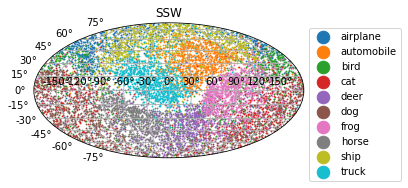

In [21]:
scatter_dists(all_z_ssw, all_y_ssw, "SSW")

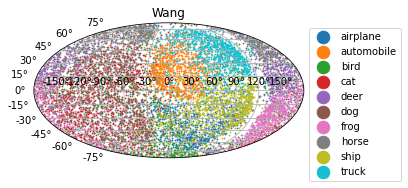

In [22]:
scatter_dists(all_z_hypersphere, all_y_hypersphere, "Wang")

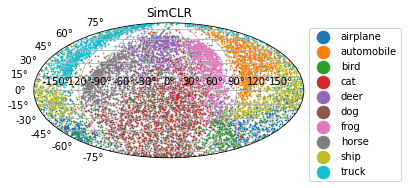

In [23]:
scatter_dists(all_z_simclr, all_y_simclr, "SimCLR")

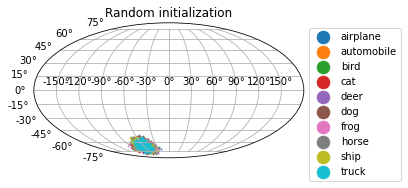

In [24]:
scatter_dists(all_z_rand, all_y_rand, "Random initialization")

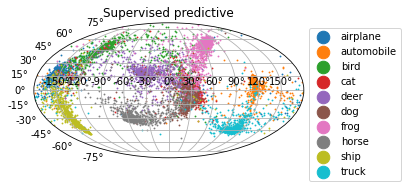

In [25]:
scatter_dists(all_z_supervised, all_y_supervised, "Supervised predictive")